In [1]:
import numpy as np
from scipy import optimize
import time
import matplotlib.pyplot as plt

## 1. Optimisation continue sous contraintes

### 1.1 Comparaison primal / dual

In [19]:
def f_optim(X):
    n=len(X)
    return sum([np.exp(X[i])+i/n*X[i] for i in range(n)])

**1.1.1 Résolution du problème primal**

For N=10 : execution time is 0.0064544677734375 seconds
Minimum of f is 11.127285422065109
For N=100 : execution time is 0.15261363983154297 seconds
Minimum of f is 97.35794605547719
For N=1000 : execution time is 18.0942325592041 seconds
Minimum of f is 959.6972632698448


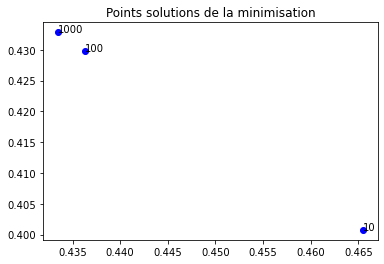

In [23]:
sol = []
dim = [10,100,1000]
for N in dim:
    start_time = time.time()
    x0 = np.random.rand(N)

    cons = ({'type': 'ineq', 'fun': lambda x:   np.sum(x) - 1})

    res = optimize.minimize(f_optim, x0, constraints=cons)
    print('For N={} : execution time is {} seconds'.format(N,time.time() - start_time))
    print('Minimum of f is {}'.format(res.fun))
    sol.append(res.x[:2])

plt.figure()
for i in range(len(sol)):
    plt.plot(sol[i][0],sol[i][1],'o',color='b')
    plt.annotate(dim[i],(sol[i][0],sol[i][1]))
plt.title('Points solutions de la minimisation')
plt.show()

On voit que pour une multiplication par 10 de l'échantillon, le temps d'éxecution a été multiplié par 100. Ceci s'explique par l'augmentation de la dimension qui ralentit les calculs.
<br>
On voit que pour la repartition des 2 premières valeurs du vecteur solution, il y a décalage des 2 premières coordonnés vers le haut-gauche. Ceci peut s'expliquer par le fait que pour grand, la discrétisation est plus importante et les valeurs s'uniformisent. On voit que pour N$\geq$100 $x_0$ et $x_1$ sont proches.

**1.1.2 Résolution du problème dual**

a) La fonction de Lagrange est:

\begin{equation*}
\mathcal{L}(x,\lambda) = \sum_{i=1}^N (exp(x^{(i)}) + p_ix^{(i)}) + \lambda(1 - \sum_{i=1}^N x^{(i)})
\\
\forall i \in [|1,n|], \ p_i = \frac{i}{N}
\end{equation*}

La fonction dual est:

\begin{equation*}
\underline{\mathcal{L}}(\lambda) = \sum_{i=1}^N ((\lambda - p_i)(1 - log(\lambda - p_i)) + \lambda  
\end{equation*}

b) Expression du problème dual

\begin{equation*}
sup_{\lambda\in \mathbf{R}} \underline{\mathcal{L}}(\lambda) \\
Pour \lambda > 0 \ et  \ \forall i\in [|1,n|]  \ \lambda > p_i \\
i.e \lambda > 1
\end{equation*}


In [4]:
def dual_f_optim(lbd):
    dual_optim = 0
    for i in range(N):
        dual_optim += (lbd - i/N)*(1 - np.log(lbd - i/N))
    return - (dual_optim + lbd)

In [5]:
for N in [10,100,1000]:
    start_time = time.time()
    
    lbd0 = np.random.uniform(1,10)
    
    res = optimize.minimize(dual_f_optim, lbd0, bounds = [(1,np.inf)])
    print('For N={} : execution time is {} seconds'.format(N,time.time() - start_time))
    #print(res)
    print('Minimum of f is {}'.format(-res.fun[0]))

For N=10 : execution time is 0.009958267211914062 seconds
Minimum of f is [-11.1272854]
For N=100 : execution time is 0.03292584419250488 seconds
Minimum of f is [-97.35794592]
For N=1000 : execution time is 0.3558192253112793 seconds
Minimum of f is [-959.69726305]


### Comparaison des résultats obtenus pour la résolution du problème dual et du problème primal

On remarque que la résolution du problème dual est beaucoup plus rapide. Le temps est divisé par presque 20.
Ceci s'explique par la simplification du problème. Dans le problème dual on résout un prblème en 1-D. Beaucoup plus facile à résoudre.
 

## Optimisation discrète

### 2.1 Rangement d'objets

### question 1

soit $(X_{i,j})$ la matrice a valeurs binaires definit par $X_{i,j}=1$ si la boite $i$ contient l'objet $j$ et $X_{i,j}=0$ si non.

la contrainte "la boite i contient un objet et un seul" est traduite par $\sum_j X_{i,j}=1$ 

la contrainte "l'objet j se trouve dans une boite et une seule" est traduite par $\sum_i X_{i,j}=1$ 

In [2]:
from mip import *

In [3]:
objet = np.loadtxt('PositionObjets.txt', skiprows =1)
boite = np.loadtxt('PositionCasiers.txt', skiprows =1)

num_objets, _ = objet.shape

### question 2

On note $D$ la matrice des distances definit par $D_{i,j}$ est la distance entre la boite i et l'objet j. 
Le probleme d'optimisation est le suivant:

minimizer $\sum_{i,j} D_{i,j}X_{i,j}$ sous contraints $\sum_j X_{i,j}=1 \; \forall i $ et $\sum_i X_{i,j}=1 \; \forall j$ 

In [4]:
from scipy.spatial import distance 

distance_matrix = [[distance.euclidean(boite[i],objet[j]) for j in range(num_objets)] for i in range(num_objets)]

In [17]:
m = Model()

x = [[m.add_var(var_type=BINARY) for j in range(num_objets)] for i in range(num_objets)]

m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(num_objets) for j in range(num_objets)))



for i in range(num_objets):
    m += xsum(x[i][j] for j in range(num_objets)) == 1

for j in range(num_objets):
    m += xsum(x[i][j] for i in range(num_objets)) == 1

m.optimize()

matrix = []
for v in m.vars:
    matrix.append(v.x)
    
matrix_1 = np.array(matrix).reshape((num_objets,num_objets))
value1=m.objective_value
print('la valeure optimale est {}'.format(value1))

la valeure optimale est 15.377627809988198


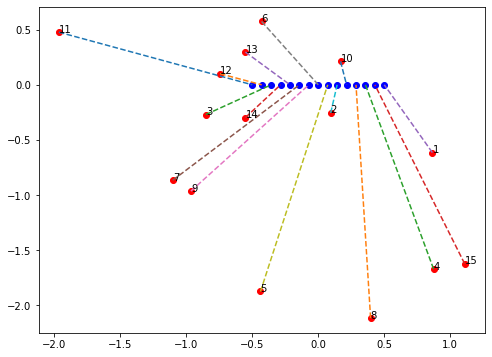

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(objet[:,0],objet[:,1],'o',color = 'r')
plt.plot(boite[:,0],boite[:,1],'o',color= 'b')
for i in range(num_objets):
    plt.annotate(i+1,(objet[i,0],objet[i,1]))
for i in range(num_objets):
    for j in range(num_objets):
        if matrix_1[i,j] >0:
            plt.plot([objet[j,0],boite[i,0]],[objet[j,1],boite[i,1]],'--')
plt.show()

### question 3

Il faut ajouter la contrainte suivante: $X_{1,2}=0$ et $X_{i,1}=X_{i+1,2}\; \forall i\in [1,n-1 ]$

In [19]:
m = Model()

x = [[m.add_var(var_type=BINARY) for j in range(num_objets)] for i in range(num_objets)]

m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(num_objets) for j in range(num_objets)))

    
for i in range(num_objets):
    m += xsum(x[i][j] for j in range(num_objets)) == 1

for j in range(num_objets):
    m += xsum(x[i][j] for i in range(num_objets)) == 1

m += x[0][1] == 0

for i in range(num_objets-1):
    m += x[i][0] - x[i+1][1] ==0


m.optimize()

matrix = []
for v in m.vars:
    matrix.append(v.x)
    
matrix_2 = np.array(matrix).reshape((num_objets,num_objets))
value2=m.objective_value
print('la valeure optimale est {}'.format(value2))


la valeure optimale est 15.565123298125489


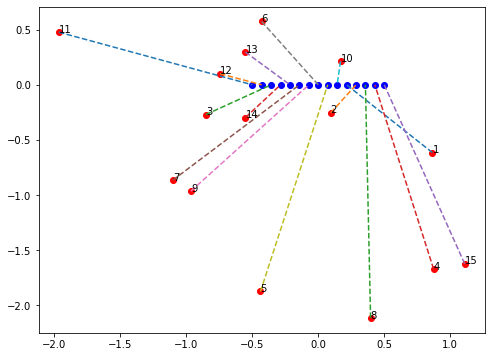

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(objet[:,0],objet[:,1],'o',color = 'r')
for i in range(num_objets):
    plt.annotate(i+1,(objet[i,0],objet[i,1]))
plt.plot(boite[:,0],boite[:,1],'o',color= 'b')
for i in range(num_objets):
    for j in range(num_objets):
        if matrix_2[i,j] >0:
            plt.plot([objet[j,0],boite[i,0]],[objet[j,1],boite[i,1]],'--')
plt.show()

### question 4

La contrainte traduit le fait que l'objet 4 est a gauche de l'objet 3

In [21]:
m = Model()

x = [[m.add_var(var_type=BINARY) for j in range(num_objets)] for i in range(num_objets)]

m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(num_objets) for j in range(num_objets)))

    
for i in range(num_objets):
    m += xsum(x[i][j] for j in range(num_objets)) == 1

for j in range(num_objets):
    m += xsum(x[i][j] for i in range(num_objets)) == 1

m += x[0][1] == 0


for i in range(num_objets-1):
    m += x[i][0] - x[i+1][1] ==0
    
for i in range(num_objets):
    m += x[i][2] + xsum(x[i+k+1][3] for k in range(num_objets-i-1)) <= 1
    
m.optimize()

matrix = []
for v in m.vars:
    matrix.append(v.x)
    
matrix_4= np.array(matrix).reshape((num_objets,num_objets))
value4=m.objective_value
print('la valeure optimale est {}'.format(value4))

la valeure optimale est 15.901379430360377


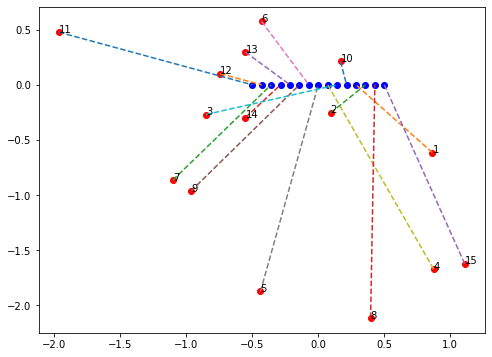

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(objet[:,0],objet[:,1],'o',color = 'r')
for i in range(num_objets):
    plt.annotate(i+1,(objet[i,0],objet[i,1]))
plt.plot(boite[:,0],boite[:,1],'o',color= 'b')
for i in range(num_objets):
    for j in range(num_objets):
        if matrix_4[i,j] >0:
            plt.plot([objet[j,0],boite[i,0]],[objet[j,1],boite[i,1]],'--')
plt.show()

### question 5

On peut formuler la contrainte autrement: l'objet 7 est situé juste à droite ou juste à gauche de l'objet 9

Mathematiquement ca se traduit par ($X_{i,7}=X_{i+1,9}\; \forall i\in [1,n-1 ]$ ou $X_{i,9}=X_{i+1,7}\; \forall i\in [1,n-1 ]$)

In [5]:
m = Model()

x = [[m.add_var(var_type=BINARY) for j in range(num_objets)] for i in range(num_objets)]

m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(num_objets) for j in range(num_objets)))

    
for i in range(num_objets):
    m += xsum(x[i][j] for j in range(num_objets)) == 1

for j in range(num_objets):
    m += xsum(x[i][j] for i in range(num_objets)) == 1
    
    
m += x[0][1] == 0


for i in range(num_objets-1):
    m += x[i][0] - x[i+1][1] ==0
    
for i in range(num_objets):
    m += x[i][2] + xsum(x[i+k+1][3] for k in range(num_objets-i-1)) <= 1    
    


for i in range(num_objets-1):
    m += x[i][6] - x[i+1][8] == 0 or x[i][8] - x[i+1][6] ==0
    
m.optimize()

matrix_optimal = []
for v in m.vars:
    matrix_optimal.append(v.x)
    
matrix_5 = np.array(matrix_optimal).reshape((num_objets,num_objets))
matrix_optimal = list(matrix_optimal)
value5 = m.objective_value
print('la valeure optimale est {}'.format(value5))

la valeure optimale est 15.904808342529503


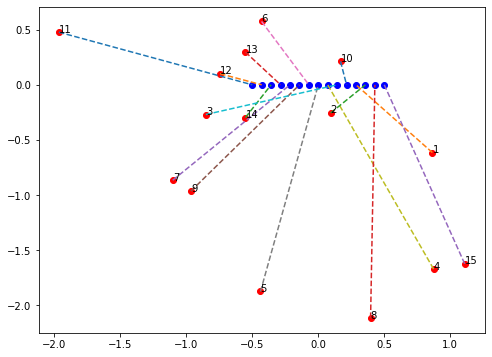

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(objet[:,0],objet[:,1],'o',color = 'r')
for i in range(num_objets):
    plt.annotate(i+1,(objet[i,0],objet[i,1]))
plt.plot(boite[:,0],boite[:,1],'o',color= 'b')
for i in range(num_objets):
    for j in range(num_objets):
        if matrix_5[i,j] >0:
            plt.plot([objet[j,0],boite[i,0]],[objet[j,1],boite[i,1]],'--')
plt.show()

### question 6

Une strategie pour verifier que la solution obtenue dans question 1 est le seule minimum: resoudre le meme probleme de minimisation en ajoutant la contrainte $X!=X_0$ tel que $X_0$ est la solution du question 1

In [19]:
m = Model()

x = [[m.add_var(var_type=BINARY) for j in range(num_objets)] for i in range(num_objets)]

m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(num_objets) for j in range(num_objets)))

    
for i in range(num_objets):
    m += xsum(x[i][j] for j in range(num_objets)) == 1

for j in range(num_objets):
    m += xsum(x[i][j] for i in range(num_objets)) == 1

m += x[0][1] == 0


for i in range(num_objets-1):
    m += x[i][0] - x[i+1][1] ==0
    
for i in range(num_objets):
    m += x[i][2] + xsum(x[i+k+1][3] for k in range(num_objets-i-1)) <= 1    
    

for i in range(num_objets-1):
    m += x[i][6] - x[i+1][8] == 0 or x[i][8] - x[i+1][6] ==0
    

m += xsum(x[i][j]*matrix_5[i,j] for i in range(num_objets) for j in range(num_objets)) <= num_objets - 1


m.optimize()

matrix = []
for v in m.vars:
    matrix.append(v.x)
    
matrix_6 = np.array(matrix).reshape((num_objets,num_objets))
print('la solution optimale avec la contrainte a un coût de {} identique à la valeur dans la question 5 {}'.format(m.objective_value, value5))

la solution optimale avec la contrainte a un coût de 15.904808342529503 identique à la valeur dans la question 5 15.904808342529503


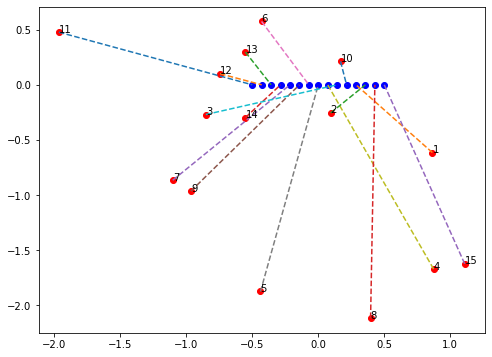

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(objet[:,0],objet[:,1],'o',color = 'r')
for i in range(num_objets):
    plt.annotate(i+1,(objet[i,0],objet[i,1]))
plt.plot(boite[:,0],boite[:,1],'o',color= 'b')
for i in range(num_objets):
    for j in range(num_objets):
        if matrix_6[i,j] >0:
            plt.plot([objet[j,0],boite[i,0]],[objet[j,1],boite[i,1]],'--')
plt.show()

In [21]:
print(matrix_6 - matrix_5)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [17]:
print("Les coordonnés de l'objet {} sont x={} y={}".format(12,objet[12][0],objet[12][1]))
print("Les coordonnés de l'objet {} sont x={} y={}".format(13,objet[13][0],objet[13][1]))

Les coordonnés de l'objet 12 sont x=-0.552307 y=0.297433
Les coordonnés de l'objet 13 sont x=-0.552307 y=-0.297433


Les boites sont alignés sur l'axe y=0 qui est la médiatrice du segment entre l'objet **12** et l'objet **13**.
En les échangeants on ne change pas la fonction à minimiser. Il n y a pas unicité de la solution 

### 2.2 Communication entre espions

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
from itertools import chain, combinations

#### question 1

On modelise les comunications entre les agents par un graph: il ya une communication entre les deux agents i et j si si et seulement si il y a une arête entre les deux noeuds.

Pour que l'information puisse être communiquée par l'agent 1 aux autres agents, il faut que le graph soit connexe. Par conséquent, il suffit d'avoir un arbre.

Donc le probleme se traduit par trouver l'arbre en minimizant $P(\cup_{i,j}A_{i,j})$ tel que $A_{i,j}$ est l'evenement d'espionnage entre les agents i et j $P(A_{i,j})=p_{i,j}$.

La minimisation de $P(\cup_{i,j}A_{i,j})$ est equivalente a minimiser $\sum_{i,j}p_{i,j}$

On peut resoudre le probleme par utilisation de l'algorithme de Kruskal

In [3]:

  # Find set of vertex i 

def find(i,parent): 
    while parent[i] != i: 
        i = parent[i] 
    return i 
  
# Does union of i and j. It returns 
# false if i and j are already in same  
# set.  
def union(i, j,parent): 
    a = find(i,parent) 
    b = find(j,parent) 
    parent[a] = b 
  
# Finds MST using Kruskal's algorithm  
def kruskalMST(cost): 
    L=np.zeros(cost.shape)
    P=[]
    E=[]
    mincost = 0 # Cost of min MST 
  
    # Initialize sets of disjoint sets 
    V=len(cost)
    parent = [i for i in range(V)] 
    for i in range(V): 
        parent[i] = i 
  
    # Include minimum weight edges one by one  
    edge_count = 0
    while edge_count < V - 1: 
        min = INF 
        a = -1
        b = -1
        for i in range(V): 
            for j in range(V): 
                if find(i,parent) != find(j,parent) and cost[i][j] < min: 
                    min = cost[i][j] 
                    a = i 
                    b = j 
        union(a, b,parent) 
        #print('Comunication_pair {}:({}, {})'.format(edge_count, a, b)) 
        L[a,b]=1
        L[b,a]=1
        E.append((a,b))
        P.append(min)
        edge_count += 1
        mincost += min
  
    return [L,P,E]
  
  
INF = float('inf') 


# Print the solution  

In [4]:
df=pd.read_table('ProbaInterception.txt', header=None, delim_whitespace=True)
Cost=np.array(df.replace(np.nan, INF))
Solution=kruskalMST(Cost)
L=Solution[0]
print('Les comunication entre agents qui presente le minium risque est', Solution[2])

Les comunication entre agents qui presente le minium risque est [(1, 3), (5, 13), (10, 13), (0, 11), (5, 14), (4, 9), (2, 13), (4, 12), (3, 7), (3, 8), (2, 6), (0, 5), (8, 10), (2, 4)]


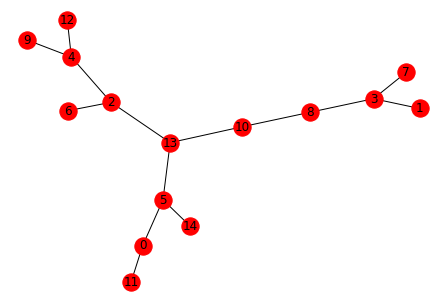

In [25]:
G = nx.from_numpy_matrix(L)  
nx.draw(G, with_labels=True,node_color="r")

On calcule $P(A_1 \cup A_2 \cdots A_n)$ en applicant $P(A\cup B)=P(A)+P(B)-P(A)P(B)$

In [5]:
P=Solution[1]
proba=0
for r in range (1,len(P)+1):
    for c in combinations(P, r):
        q=1
        for x in c:
            q=q*x
        proba=proba+((-1)**(r+1))*q
        
print('La probabilite d interception est :', proba )

La probabilite d interception est : 0.5809187658378511


### 2.3 Approvisionnement d’un chantier

Pour résoudre ce problème nous allons transformer le problème en un **problème de plus court chemin dans un graph**.
En s'inspirant du graphique suivant vue en cours:

<img src="exercice 2-3.png" alt="Drawing" style="width: 600px;"/>

On garde le même axe des abscisses (chaque instant coorespond à une semaine) . On remplace l'axe des ordonnées par le nombre de camions alloués chaque semaine. Chaque semaine i, le nombre de camions doit être supérieur à $d_i$ par contrainte mais il doit aussi être inférieur $max_i \ d_i$ car on aurait des camions qui ne seraient pas utilisés. On construit par la suite le graph en utilisant le module dijkstra. Chaque noeud est de la forme $i-c_i$ où 
- i correspond à la semaine i
- $c_i$ correspond aux nombres de camions alloués à cette semaine

In [5]:
from dijkstra import Graph,DijkstraSPF

In [10]:
planning = np.loadtxt('DonneesEnginsChantier.txt',dtype=int)
 

N = len(planning)
p_init = 800
p_loc = 200
p_fin = 1200
max_planning = (np.max(planning))

In [11]:
graph = Graph()

    
for i in range(N):
    if i==0:
        for commande in range(planning[i],max_planning+1):
            graph.add_edge('0-0','1-'+str(commande),(p_init+p_loc)*commande)
            
    elif i == N-1:
        for prev_commande in range(planning[i-1],max_planning+1):
            delta = planning[N-1] - prev_commande
            if delta >= 0:
                    graph.add_edge(str(i)+'-'+str(prev_commande),
                              str(N)+'-'+str(planning[N-1]),
                              p_init*delta+p_loc*commande)
            else:
                graph.add_edge(str(i)+'-'+str(prev_commande),
                              str(N)+'-'+str(planning[N-1]),
                              -p_fin*delta+p_loc*commande)
    else:
        for commande in range(planning[i],max_planning+1):
            for prev_commande in range(planning[i-1],max_planning+1):
                delta = commande - prev_commande
                if delta >= 0:
                    graph.add_edge(str(i)+'-'+str(prev_commande),
                              str(i+1)+'-'+str(commande),
                              p_init*delta+p_loc*commande)
                else:
                    graph.add_edge(str(i)+'-'+str(prev_commande),
                              str(i+1)+'-'+str(commande),
                              -p_fin*delta+p_loc*commande)
            

dijkstra = DijkstraSPF(graph, '0-0')

In [12]:
print('Le coût total pour les {} semaines est de {}'.format(N, 
                                                            dijkstra.get_distance('{}-{}'.format(N,planning[N-1]))))

Le coût total pour les 99 semaines est de 3166600


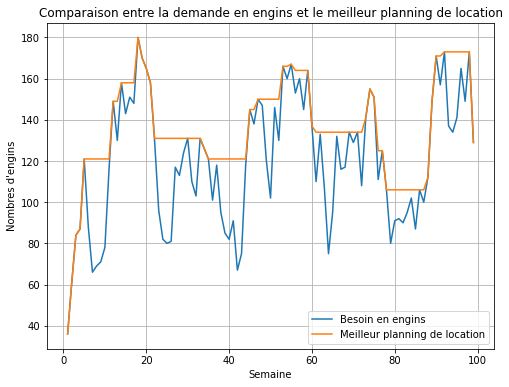

In [16]:
path = dijkstra.get_path('{}-{}'.format(N,planning[N-1]))
best_planning = np.zeros(N+1)

for i in range(N+1):
    value = path[i].split('-')[1]
    best_planning[i] = int(value)

plt.figure(figsize=(8,6))
plt.plot(list(range(1,N+1)),planning,'-',label = 'Besoin en engins')
plt.plot(list(range(1,N+1)),best_planning[1:],'-', label = 'Meilleur planning de location')
plt.xlabel('Semaine')
plt.ylabel("Nombres d'engins")
plt.grid()
plt.title('Comparaison entre la demande en engins et le meilleur planning de location')
plt.legend()
plt.show()

On voit que le planning proposé par l'algorithme du plus court chemin semble cohérent. Le planning ne prend pas en compte les creux dans le planning. En effet, le coût de récupération des camions est très élevé. Il est plus avatageux de les garder pour quelques semaines sans les utiliser que de les rendre.

## 3  Optimisation multi-objectif: dimensionnement d'une poutre

### Justification de la methode
Plus on ajoute des points aleatoires (a,b) dans le plan plus on evalue presque tous les valeurs des deux objectifs p et d, donc lorsque N tend vers l'infini les valeurs minimales de p et d dans ce nuage de N points convergent vers les vrais valeurs minimales.

### La strategie pour trouver le front du rang 1
On utilise une strategie naive: Initialiser une liste des points vide K. parcourir tous les points (p,d), et à chaque etape on verifie s'il y a un autre point qui domine le point (p,d) par un autre parcours de point. Si oui on n'ajoute pas le point a la liste K, sinon on ajoute le point a la liste K.

### L'efficacite de la methode en fonction de N
Plus N est grand plus le front de pareto est bien proche de la courbe de pareto. Mais la complexite de l'algorithme de recherche du front est $O(n^2)$

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import oapackage
import scipy as sp
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
#definition des fonctions poids et deflexion
def p(a,b):
    return -(a**2 -b**2)
def d(a,b):
    return -(10**(-4))/(10**-2 +a**4 -b**4)

<function matplotlib.pyplot.show(*args, **kw)>

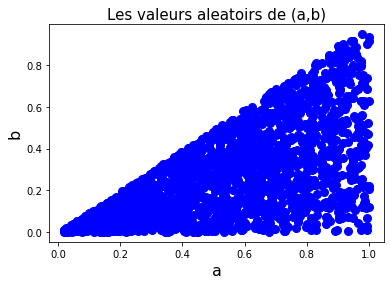

In [4]:
N=2000
datapoints=np.array([[],[]])#matrice des valeurs (a,b)
objectifs=np.array([[],[]])#matrice des paleurs (p,d)
# cree un ensemble aleatoire de couple (a,b) verifiant les contrainte
for i in range(N):
    a=np.random.uniform(0.02,1)
    b=np.random.uniform(0,a-0.01)
    datapoints=np.append(datapoints, np.array([[a],[b]]), axis=1)
    objectifs=np.append(objectifs, np.array([[p(a,b)],[d(a,b)]]), axis=1)

h=plt.plot(datapoints[0,:], datapoints[1,:], '.b', markersize=16)
_=plt.title('Les valeurs aleatoirs de (a,b)', fontsize=15)
plt.xlabel('a', fontsize=16)
plt.ylabel('b', fontsize=16)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

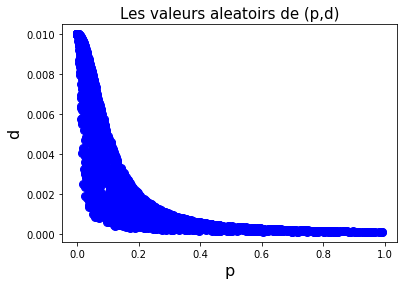

In [5]:
h=plt.plot(-objectifs[0,:], -objectifs[1,:], '.b', markersize=16, label='Non Pareto-optimal')
_=plt.title('Les valeurs aleatoirs de (p,d)', fontsize=15)
plt.xlabel('p', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

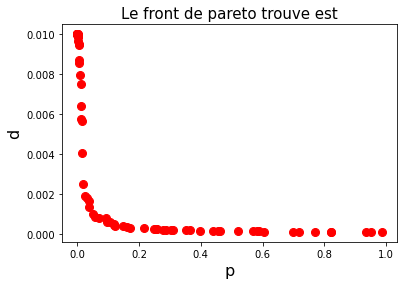

In [6]:
def front_pareto(M):#fonction de recherche du front de pareto
    K=np.array([[],[]])
    for i in range(len(M[0])):
        j=0
        ad=True
        for j in range (len(M[0])):
            if M[0,j]< M[0,i] and  M[1,j]< M[1,i]:#condition de domination
                ad=False
                break  #arreter le boucle j de qu'on trouve que le point i est dominee
        if ad==True:
            K=np.append(K, np.array([[M[0,i]],[M[1,i]]]), axis=1)
    return K

Y=-objectifs
K=front_pareto(Y)# La liste des points du frontdu premier ordre
h=plt.plot(K[0,:], K[1,:], '.r', markersize=16)
_=plt.title('Le front de pareto trouve est', fontsize=15)
plt.xlabel('p', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.show
                

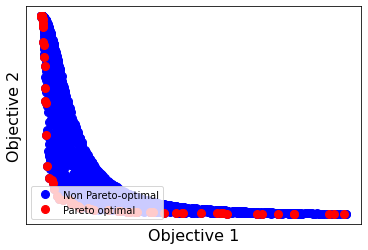

In [7]:
h=plt.plot(-objectifs[0,:], -objectifs[1,:], '.b', markersize=16, label='Non Pareto-optimal')
hp=plt.plot(K[0,:], K[1,:], '.r', markersize=16, label='Pareto optimal')
plt.xlabel('Objective 1', fontsize=16)
plt.ylabel('Objective 2', fontsize=16)
plt.xticks([])
plt.yticks([])
_=plt.legend(loc=3, numpoints=1)

### Methode plus sophistique

La methode utilise ici est de fixer la valeure du poids $p_{fix}$ et minimiser $d(a,b)$ sous les contraintes mentionnées en plus de la contrainte $p_{fix}$, puis on fait varier la valeur de $p_{fix}$

In [33]:
def p(x):
    return (x[0]**2 -x[1]**2)
def d(x):
    return (10**(-4))/(10**-2 +x[0]**4 -x[1]**4)

poids=np.arange(0,1,0.001)
deflexion=np.array([])
for i in range(0,len(poids)):
    x0=np.array([1,np.sqrt(1-poids[i])])
    con1={'type':'ineq','fun': lambda x: x[1]-x[0]+0.01}
    con3={'type':'eq','fun': lambda x: p(x) -poids[i]}
    cons=[con1,con3]
    sol=minimize(d,x0,method='SLSQP', constraints=cons, bounds=[(0.02,1),(0,1)])
    deflexion=np.append(deflexion,sol.fun)

Text(0, 0.5, 'deflexion')

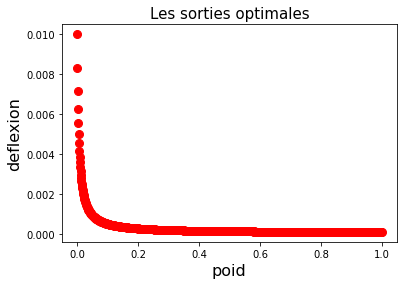

In [34]:
plt.plot(poids, deflexion, '.r', markersize=16)
_=plt.title('Les sorties optimales', fontsize=15)
plt.xlabel('poid', fontsize=16)
plt.ylabel('deflexion', fontsize=16)

### Bonus

In [10]:
#trouver le front de pareto a partir de lamatrice objectifs de (p,d)
pareto=oapackage.ParetoDoubleLong()
for ii in range(0, objectifs.shape[1]):
    w=oapackage.doubleVector( (objectifs[0,ii], objectifs[1,ii]))
    pareto.addvalue(w, ii)

pareto.show(verbose=1)

lst=pareto.allindices() #les indices des valeurs pareto optimals

optimal_objectifs=objectifs[:,lst]#le valeurs pareto optimal


Pareto: 76 optimal values, 76 objects


Text(0, 0.5, 'b')

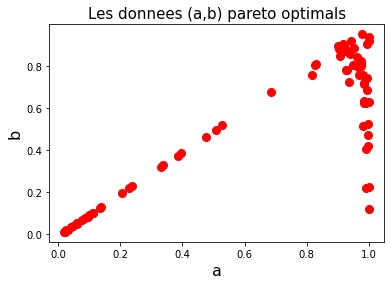

In [11]:
optimal_inputs=datapoints[:,lst]# les valeurs des (a,b) correspends aux valeurs pareto optimals

hp=plt.plot(optimal_inputs[0,:], optimal_inputs[1,:], '.r', markersize=16, label='Pareto optimal')
_=plt.title('Les donnees (a,b) pareto optimals', fontsize=15)
plt.xlabel('a', fontsize=16)
plt.ylabel('b', fontsize=16)

ici on trace uniquement le front de pareto

Text(0, 0.5, 'deflexion')

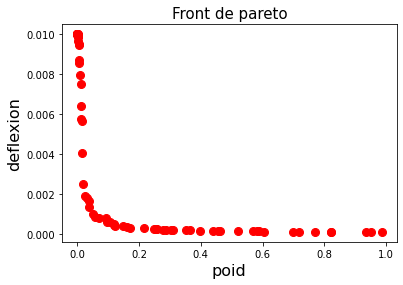

In [12]:
plt.plot(-optimal_objectifs[0,:], -optimal_objectifs[1,:], '.r', markersize=16)
_=plt.title('Front de pareto', fontsize=15)
plt.xlabel('poid', fontsize=16)
plt.ylabel('deflexion', fontsize=16)